# Importing libraries

In [7]:
# !pip install imutils

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [9]:
# Defining Global Variables
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
image_size = 150
# 'C:\\Users\\98939\\Desktop\\BC_Project\\Data'
# 'Training'

In [18]:
def image_resizer(initialPath, TrainPath, TestPath):
    X_train = []
    y_train = []
    for i in labels:
        folderPath = os.path.join(initialPath,TrainPath,i)
        for j in tqdm(os.listdir(folderPath)):
            img = cv2.imread(os.path.join(folderPath,j))
            img = cv2.resize(img,(image_size, image_size))
            X_train.append(img)
            y_train.append(i)

    for i in labels:
        folderPath = os.path.join(initialPath,TestPath,i)
        for j in tqdm(os.listdir(folderPath)):
            img = cv2.imread(os.path.join(folderPath,j))
            img = cv2.resize(img,(image_size,image_size))
            X_train.append(img)
            y_train.append(i)

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    return X_train, y_train

In [21]:
X_train, y_train = image_resizer('C:\\Users\\98939\\Desktop\\BC_Project\\Data','Training','Testing')

100%|█████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 216.91it/s]


# ! Under Construction !

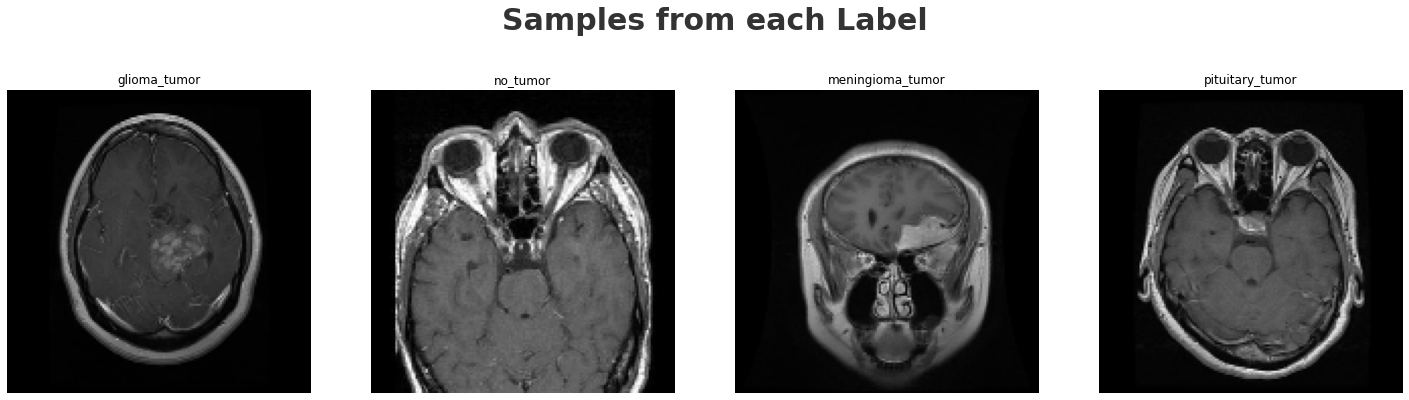

In [23]:
k = 0
fig, ax = plt.subplots(1,4,figsize=(25,25))
fig.text(s='Samples from each Label', size = '30',fontweight='bold',y=0.62,x=0.4,alpha=0.8)

for i in labels:
    j=0 
    while True:
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [24]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state = 1)

In [25]:
X_train.shape

(3264, 150, 150, 3)

In [26]:
# Splitting the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size=0.1, random_state=11)

In [28]:
def label_categorizer(init_list):
    temp_list = []
    for i in init_list:
        temp_list.append(labels.index(i))
    final_list = temp_list
    final_list = tf.keras.utils.to_categorical(final_list)
    
    return final_list 


In [30]:
y_train = label_categorizer(y_train)

In [31]:
y_test = label_categorizer(y_test)

In [32]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [33]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [16]:
# model.summary()

In [34]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [35]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [36]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =15, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

C:\Users\98939\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/15
83/83 [==============================] - 39s 297ms/step - loss: 0.4706 - accuracy: 0.8233 - val_loss: 0.9721 - val_accuracy: 0.6871

Epoch 00001: val_accuracy improved from -inf to 0.68707, saving model to effnet.h5
Epoch 2/15
83/83 [==============================] - 20s 241ms/step - loss: 0.1916 - accuracy: 0.9330 - val_loss: 0.4266 - val_accuracy: 0.8639

Epoch 00002: val_accuracy improved from 0.68707 to 0.86395, saving model to effnet.h5
Epoch 3/15
83/83 [==============================] - 20s 242ms/step - loss: 0.1246 - accuracy: 0.9550 - val_loss: 0.5931 - val_accuracy: 0.8197

Epoch 00003: val_accuracy did not improve from 0.86395
Epoch 4/15
83/83 [==============================] - 20s 241ms/step - loss: 0.0821 - accuracy: 0.9697 - val_loss: 3.1708 - val_accuracy: 0.3673

Epoch 00004: val_accuracy did not improve from 0.86395

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/15
83/83 [==============================] - 20s 243ms/st

C:\Users\98939\AppData\Local\Temp\ipykernel_17108\4117282077.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


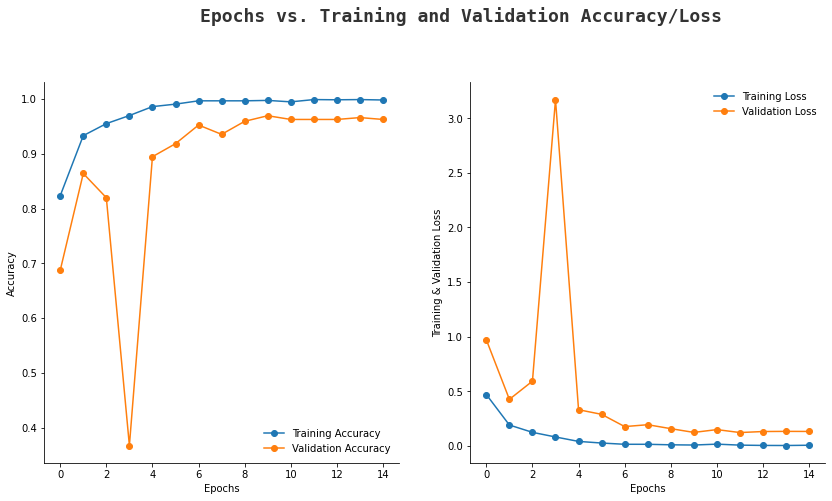

In [38]:
epochs = [i for i in range(15)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()